In [1]:
# Import Libraries 
!pip install seaborn

import time
import joblib
import random 
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.layers import LSTM, Input, Dropout, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Bidirectional
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin


[notice] A new release of pip is available: 23.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


2025-01-30 06:51:21.409265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-30 06:51:21.409375: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-30 06:51:21.409420: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    except RuntimeError as e:
        print(e)

2025-01-30 06:51:25.050520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-30 06:51:25.060836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-30 06:51:25.061048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.


/tmp/ipykernel_545/2068608123.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(0, 0.01, inplace=True)


Number of rows where zero values were replaced: 127981
Remaining rows with zero values: 0
Start date is: 2025-01-06 05:41:25
End date is: 2025-01-13 19:41:25


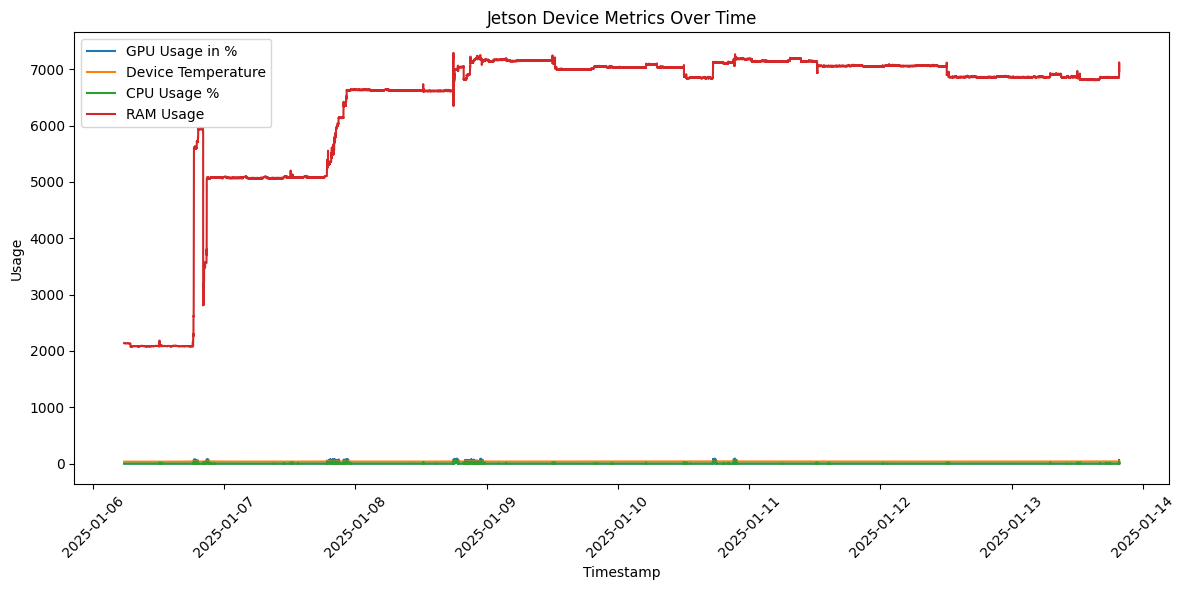

In [3]:
# Set random seed 
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load the dataset
data1 = pd.read_csv('nano07_short.csv')
dataframe = data1

# Convert 'timestamp' column to datetime
dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])

# Filter relevant columns
df = dataframe[['timestamp', 'jetson_gpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_cpu_usage_percent', 'jetson_ram_usage_mb']]
df.set_index('timestamp', inplace=True)
# Replace zero values with 0.01
df.replace(0, 0.01, inplace=True)

# Count the number of rows where zero values were replaced with 0.01
num_rows_with_zero_replaced = len(df[(df == 0.01).any(axis=1)])
print(f"Number of rows where zero values were replaced: {num_rows_with_zero_replaced}")

# check if there are any remaining zero values
remaining_zeros = df[(df == 0).any(axis=1)]
print(f"Remaining rows with zero values: {len(remaining_zeros)}")

# Keep only rows with timestamps every 5 seconds
#df = df[df.index.second % 5 == 0]
    
# Print start and end date
print("Start date is:", df.index.min())
print("End date is:", df.index.max())

# Create the line plot
plt.figure(figsize=(12, 6))
# sns.lineplot(x=df.index, y='jetson_vdd_cpu_gpu_cv_mw', data=df, label='GPU/CPU Power')
sns.lineplot(x=df.index, y='jetson_gpu_usage_percent', data=df, label='GPU Usage in %')
sns.lineplot(x=df.index, y='jetson_board_temperature_celsius', data=df, label='Device Temperature')
# sns.lineplot(x=df.index, y='jetson_vdd_in_mw', data=df, label='Total Power')
sns.lineplot(x=df.index, y='jetson_cpu_usage_percent', data=df, label='CPU Usage %')
sns.lineplot(x=df.index, y='jetson_ram_usage_mb', data=df, label='RAM Usage')
# sns.lineplot(x=df.index, y='node_network_receive_bytes_total_KBps', data=df, label='Network Received')
# sns.lineplot(x=df.index, y='node_network_transmit_bytes_total_KBps', data=df, label='Network Transmit')
plt.title('Jetson Device Metrics Over Time')
plt.ylabel('Usage')
plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.gcf().set_facecolor('white')
plt.legend()
plt.tight_layout()
plt.show()

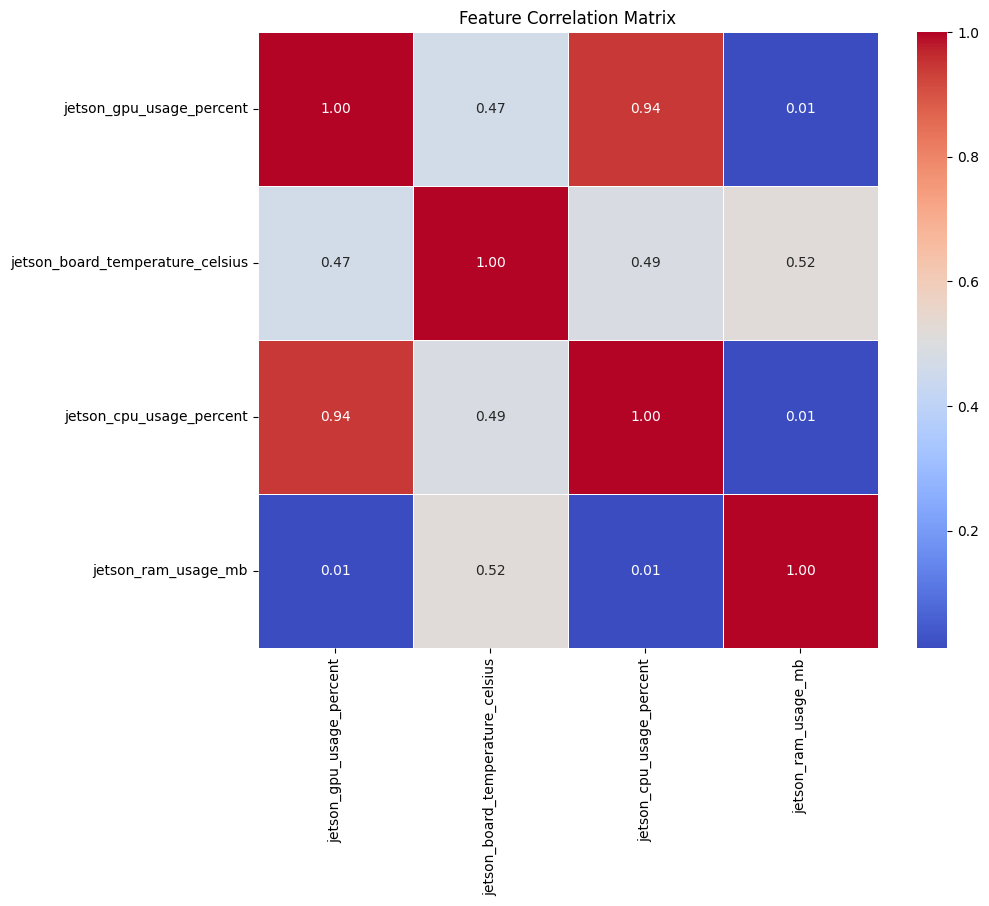

In [4]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()



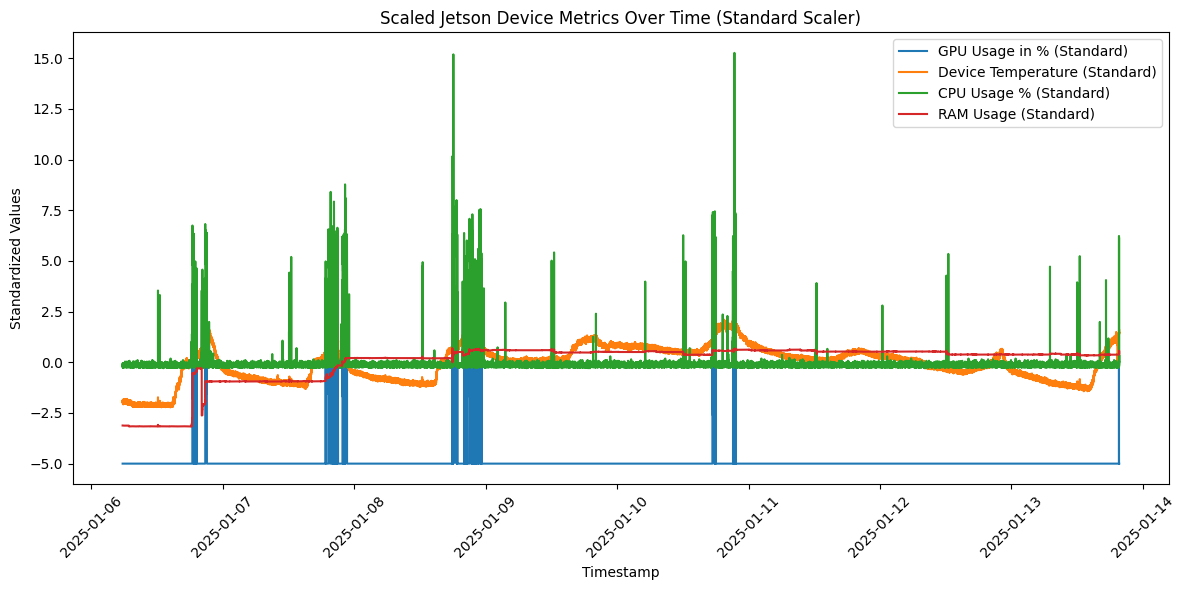

In [5]:
class GPUUsageScaler(BaseEstimator, TransformerMixin):
    """
    A custom scaler for GPU usage data that handles idle and active states differently.
    Inherits from sklearn's BaseEstimator and TransformerMixin.
    
    Parameters:
    -----------
    idle_threshold : float, default=1.0
        Values below or equal to this threshold are considered idle state
    idle_scale : float, default=-5.0
        The value to which idle state data will be scaled
    """
    def __init__(self, idle_threshold=1.0, idle_scale=-5.0):
        self.mean_idle_ = None       # Mean of idle state values
        self.std_idle_ = None        # Standard deviation of idle state values
        self.mean_active_ = None     # Mean of active state values
        self.std_active_ = None      # Standard deviation of active state values
        self.idle_threshold = idle_threshold
        self.idle_scale = idle_scale

    def fit(self, X, y=None):
        """
        Fit the scaler to the data by computing necessary statistics.
        
        Parameters:
        -----------
        X : array-like
            The data to fit
        y : None
            Ignored. Exists for compatibility with sklearn API.
            
        Returns:
        --------
        self : object
            Returns the instance itself
        """
        X = np.asarray(X).reshape(-1, 1)
        
        # Split data into idle and active states
        idle_mask = X <= self.idle_threshold
        active_mask = X > self.idle_threshold
        
        # Compute statistics for idle state
        if np.any(idle_mask):
            self.mean_idle_ = np.mean(X[idle_mask])
            self.std_idle_ = np.std(X[idle_mask]) if np.std(X[idle_mask]) > 0 else 0.1
        else:
            self.mean_idle_ = 0
            self.std_idle_ = 0.1
        
        # Compute statistics for active state
        if np.any(active_mask):
            self.mean_active_ = np.mean(X[active_mask])
            self.std_active_ = np.std(X[active_mask]) if np.std(X[active_mask]) > 0 else 1
        else:
            self.mean_active_ = self.idle_threshold
            self.std_active_ = 1
            
        return self

    def transform(self, X):
        """
        Transform the data using the fitted scaler.
        
        Parameters:
        -----------
        X : array-like
            The data to transform
            
        Returns:
        --------
        scaled : ndarray
            The scaled data
        """
        X = np.asarray(X).reshape(-1, 1)
        scaled = np.zeros_like(X)
        
        # Apply different scaling for idle and active states
        idle_mask = X <= self.idle_threshold
        active_mask = X > self.idle_threshold
        
        if np.any(idle_mask):
            # Map all idle state values to idle_scale
            scaled[idle_mask] = self.idle_scale
            
        if np.any(active_mask):
            # Standardize active state values
            scaled[active_mask] = (X[active_mask] - self.mean_active_) / self.std_active_
            
        return scaled

    def inverse_transform(self, X):
        """
        Transform scaled data back to original scale.
        
        Parameters:
        -----------
        X : array-like
            The scaled data to inverse transform
            
        Returns:
        --------
        original : ndarray
            The inverse transformed data
        """
        X = np.asarray(X).reshape(-1, 1)
        original = np.zeros_like(X)
        
        # Determine states based on scaled values
        idle_mask = X <= (self.idle_scale / 2)
        active_mask = X > (self.idle_scale / 2)
        
        if np.any(idle_mask):
            # Map idle state back to zero
            original[idle_mask] = 0.0
            
        if np.any(active_mask):
            # Inverse transform active state values
            original[active_mask] = (X[active_mask] * self.std_active_) + self.mean_active_
            
        # Ensure values are within valid range
        original = np.clip(original, 0, 100)
        
        return original


# Scaling the dataset
df_to_scale = df[['jetson_gpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_cpu_usage_percent', 'jetson_ram_usage_mb']]

# Separate scaling for each feature
gpu_scaler = GPUUsageScaler(idle_threshold=1.0, idle_scale=-5.0)
temp_scaler = StandardScaler()
cpu_scaler = StandardScaler()
ram_scaler = StandardScaler()

# Scale features individually
scaled_gpu = gpu_scaler.fit_transform(df_to_scale['jetson_gpu_usage_percent'].values.reshape(-1, 1))
scaled_temp = temp_scaler.fit_transform(df_to_scale['jetson_board_temperature_celsius'].values.reshape(-1, 1))
scaled_cpu = cpu_scaler.fit_transform(df_to_scale['jetson_cpu_usage_percent'].values.reshape(-1, 1))
scaled_ram = ram_scaler.fit_transform(df_to_scale['jetson_ram_usage_mb'].values.reshape(-1, 1))

# Create scaled DataFrame
df_scaled = pd.DataFrame({'jetson_gpu_usage_percent': scaled_gpu.flatten(),
    'jetson_board_temperature_celsius': scaled_temp.flatten(),
    'jetson_cpu_usage_percent': scaled_cpu.flatten(),
    'jetson_ram_usage_mb': scaled_ram.flatten()
}, index=df.index)

df_standard_scaled = df_scaled

plt.figure(figsize=(12, 6))
# sns.lineplot(x=df_standard_scaled.index, y='jetson_vdd_cpu_gpu_cv_mw', data=df_standard_scaled, label='GPU/CPU Power (Standard')
sns.lineplot(x=df_standard_scaled.index, y='jetson_gpu_usage_percent', data=df_standard_scaled, label='GPU Usage in % (Standard)')
sns.lineplot(x=df_standard_scaled.index, y='jetson_board_temperature_celsius', data=df_standard_scaled, label='Device Temperature (Standard)')
# sns.lineplot(x=df_standard_scaled.index, y='jetson_vdd_in_mw', data=df_standard_scaled, label='Total Power (Standard)')
sns.lineplot(x=df_standard_scaled.index, y='jetson_cpu_usage_percent', data=df_standard_scaled, label='CPU Usage % (Standard)')
sns.lineplot(x=df_standard_scaled.index, y='jetson_ram_usage_mb', data=df_standard_scaled, label='RAM Usage (Standard)')
# sns.lineplot(x=df_standard_scaled.index, y='node_network_receive_bytes_total_KBps', data=df_standard_scaled, label='Network Received (Standard)')
# sns.lineplot(x=df_standard_scaled.index, y='node_network_transmit_bytes_total_KBps', data=df_standard_scaled, label='Network Transmit (Standard)')
plt.title('Scaled Jetson Device Metrics Over Time (Standard Scaler)')
plt.ylabel('Standardized Values')
plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.gcf().set_facecolor('white')
plt.legend()
plt.tight_layout()
plt.show()

Train start date: 2025-01-06 05:41:25
Train end date: 2025-01-13 19:41:25
Train set shape: (131041, 4)


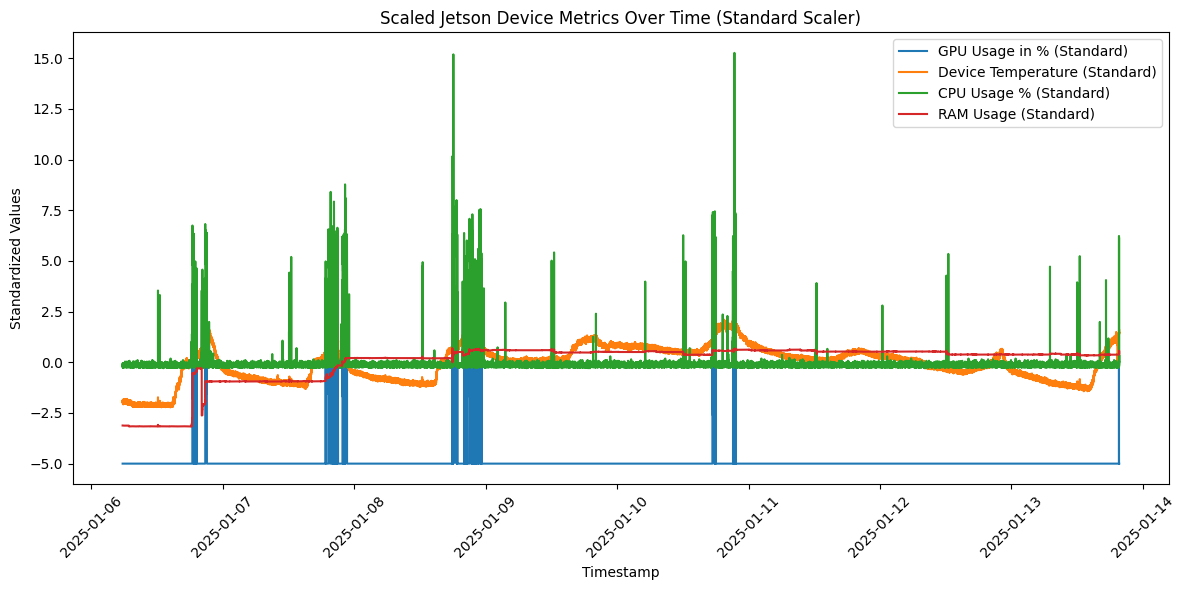

In [6]:
# Treat the entire dataset as training data
train = df_standard_scaled  # Use the entire dataset as training data

# Print the start and end dates for the dataset
print("Train start date:", train.index.min())
print("Train end date:", train.index.max())
print("Train set shape:", train.shape)

# Plot the standardized metrics
plt.figure(figsize=(12, 6))
sns.lineplot(x=train.index, y='jetson_gpu_usage_percent', data=train, label='GPU Usage in % (Standard)')
sns.lineplot(x=train.index, y='jetson_board_temperature_celsius', data=train, label='Device Temperature (Standard)')
sns.lineplot(x=train.index, y='jetson_cpu_usage_percent', data=train, label='CPU Usage % (Standard)')
sns.lineplot(x=train.index, y='jetson_ram_usage_mb', data=train, label='RAM Usage (Standard)')

# Add titles and labels
plt.title('Scaled Jetson Device Metrics Over Time (Standard Scaler)')
plt.ylabel('Standardized Values')
plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.gcf().set_facecolor('white')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [7]:
seq_size = 20 # Number of time steps to look back 
# larger sequence size (look further back) may improve forecasting 

def to_sequence(x, y, seq_size=1):
    x_values = []
    y_values = []
    
    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequence(train[['jetson_gpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_cpu_usage_percent', 'jetson_ram_usage_mb']], train[['jetson_gpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_cpu_usage_percent', 'jetson_ram_usage_mb']], seq_size)
# testX, testY = to_sequence(test[['jetson_gpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_cpu_usage_percent', 'jetson_ram_usage_mb']], test[['jetson_gpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_cpu_usage_percent', 'jetson_ram_usage_mb']], seq_size)

print("train X shape", trainX.shape)
print("train Y shape", trainY.shape)
# print("test X shape", testX.shape)
# print("test Y shape", testY.shape)

train X shape (131021, 20, 4)
train Y shape (131021, 4)


In [28]:

# Define iRMSE function
# def irmse(y_true, y_pred):
#     rmse_value = K.sqrt(K.mean(K.square(y_true - y_pred)))
#     # Avoid division by zero
#     return 1 / (rmse_value + K.epsilon())


# Define RMSE function
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

# Define the model
# LSTM
#model = Sequential()
#model.add(LSTM(64, activation='tanh', recurrent_activation='sigmoid', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
#model.add(LSTM(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
#model.add(RepeatVector(trainX.shape[1]))
#model.add(LSTM(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
#model.add(LSTM(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
#model.add(TimeDistributed(Dense(trainX.shape[2])))

# # BiLSTM
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='tanh', recurrent_activation='sigmoid', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)))
# # model.add(Bidirectional(LSTM(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)))
model.add(Bidirectional(LSTM(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=False)))
model.add(RepeatVector(trainX.shape[1]))
# # model.add(Bidirectional(LSTM(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)))
model.add(Bidirectional(LSTM(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)))
model.add(Bidirectional(LSTM(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)))
model.add(TimeDistributed(Dense(trainX.shape[2])))

# Compile the model with RMSE as a metric
model.compile(optimizer= Adam(learning_rate=0.0001) , loss='mse', metrics=[rmse])

# # Compile the model with RMSE and iRMSE as metrics
# model.compile(optimizer='adam', loss='mse', metrics=[rmse, irmse])

# model.summary()

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_rmse',   
    patience=5,          
    restore_best_weights=True, 
    verbose=1            
)

# Measure the time
start_training_time = time.time()

# Fit the model with EarlyStopping
history = model.fit(
    trainX, trainX,
    epochs=50,                  
    batch_size=128,
    validation_split=0.2,
    verbose=1,
    # callbacks=[early_stopping] 
)

end_training_time = time.time()
training_time = end_training_time - start_training_time
print(f"Total training time: {training_time:.2f} seconds")


Epoch 1/50
819/819 [==============================] - 71s 59ms/step - loss: 0.5262 - rmse: 0.5436 - val_loss: 0.0131 - val_rmse: 0.0885
Epoch 2/50
819/819 [==============================] - 44s 54ms/step - loss: 0.0492 - rmse: 0.2154 - val_loss: 0.0076 - val_rmse: 0.0594
Epoch 3/50
819/819 [==============================] - 42s 52ms/step - loss: 0.0355 - rmse: 0.1828 - val_loss: 0.0063 - val_rmse: 0.0521
Epoch 4/50
819/819 [==============================] - 44s 54ms/step - loss: 0.0314 - rmse: 0.1718 - val_loss: 0.0057 - val_rmse: 0.0501
Epoch 5/50
819/819 [==============================] - 43s 53ms/step - loss: 0.0290 - rmse: 0.1656 - val_loss: 0.0051 - val_rmse: 0.0467
Epoch 6/50
819/819 [==============================] - 43s 53ms/step - loss: 0.0274 - rmse: 0.1608 - val_loss: 0.0049 - val_rmse: 0.0464
Epoch 7/50
819/819 [==============================] - 42s 51ms/step - loss: 0.0261 - rmse: 0.1574 - val_loss: 0.0046 - val_rmse: 0.0459
Epoch 8/50
819/819 [============================

In [29]:
# Save Trained Model
joblib.dump(model, "NFL-BiLSTM-Nano08.joblib")

['NFL-BiLSTM-Nano08.joblib']

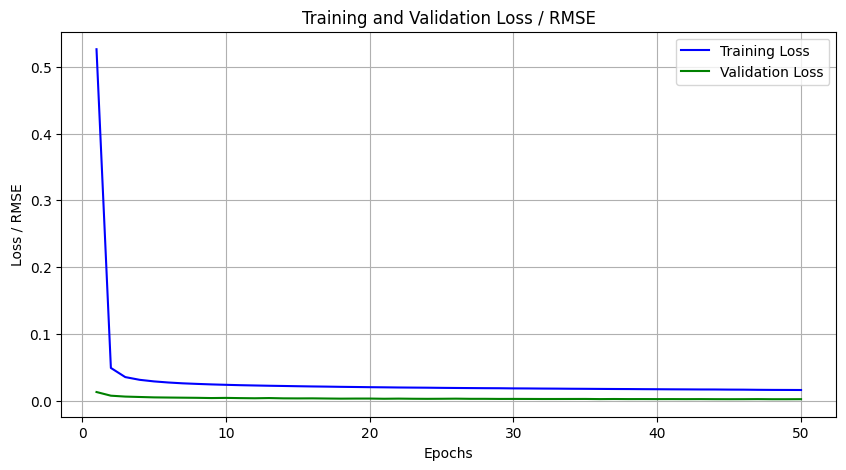

Final Training Loss: 0.01614333502948284
Final Validation Loss: 0.0024277647025883198
Final Training RMSE: 0.12401500344276428
Final Validation RMSE: 0.039412517100572586


In [32]:
# training history
training_loss = history.history['loss']
training_mape = history.history['rmse']
val_loss = history.history['val_loss']
val_mape = history.history['val_rmse']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 5))

# Plot training and validation loss 
plt.plot(epochs, training_loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')

# # Plot training and validation MAPE 
# plt.plot(epochs, training_mape, color='orange', label='Training RMSE')
# plt.plot(epochs, val_mape, color='red', label='Validation RMSE')

plt.title('Training and Validation Loss / RMSE')
plt.xlabel('Epochs')
plt.ylabel('Loss / RMSE')
plt.grid(True)
plt.legend()
plt.show()

# Extract the final loss and MAPE values
final_training_loss = training_loss[-1]
final_val_loss = val_loss[-1]
final_training_mape = training_mape[-1]
final_val_mape = val_mape[-1]

# Print the final loss and MAPE values
print("Final Training Loss:", final_training_loss)
print("Final Validation Loss:", final_val_loss)
print("Final Training RMSE:", final_training_mape)
print("Final Validation RMSE:", final_val_mape)


In [33]:
# Calculate MAE for training prediction
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
# Print the mean of test MAE
print("Mean of Train MAE:", np.mean(trainMAE))

print(trainMAE.shape)

# Calculate MSE for training predictions
trainMSE = np.mean(np.square(trainPredict - trainX), axis=1)

# Calculate RMSE for training predictions
trainRMSE = np.sqrt(trainMSE)

# Print the mean of Train MSE and Train RMSE
print("Mean of Train MSE:", np.mean(trainMSE))
print("Mean of Train RMSE:", np.mean(trainRMSE))

print("Shape of trainMSE:", trainMSE.shape)
print("Shape of trainRMSE:", trainRMSE.shape)

2025-01-30 08:11:08.042382: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 41926720 exceeds 10% of free system memory.
2025-01-30 08:11:08.130075: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 41926720 exceeds 10% of free system memory.


4095/4095 [==============================] - 79s 18ms/step
Mean of Train MAE: 0.03360913917617697
(131021, 4)
Mean of Train MSE: 0.013178643936844796
Mean of Train RMSE: 0.04402609967672613
Shape of trainMSE: (131021, 4)
Shape of trainRMSE: (131021, 4)


Shape of trainRMSE_mean: (131021,)
Mean of trainRMSE_mean: 0.04402609967672613
95th Percentile Threshold: 0.06819470232623505
99.5th Percentile Threshold: 0.48695901473262954


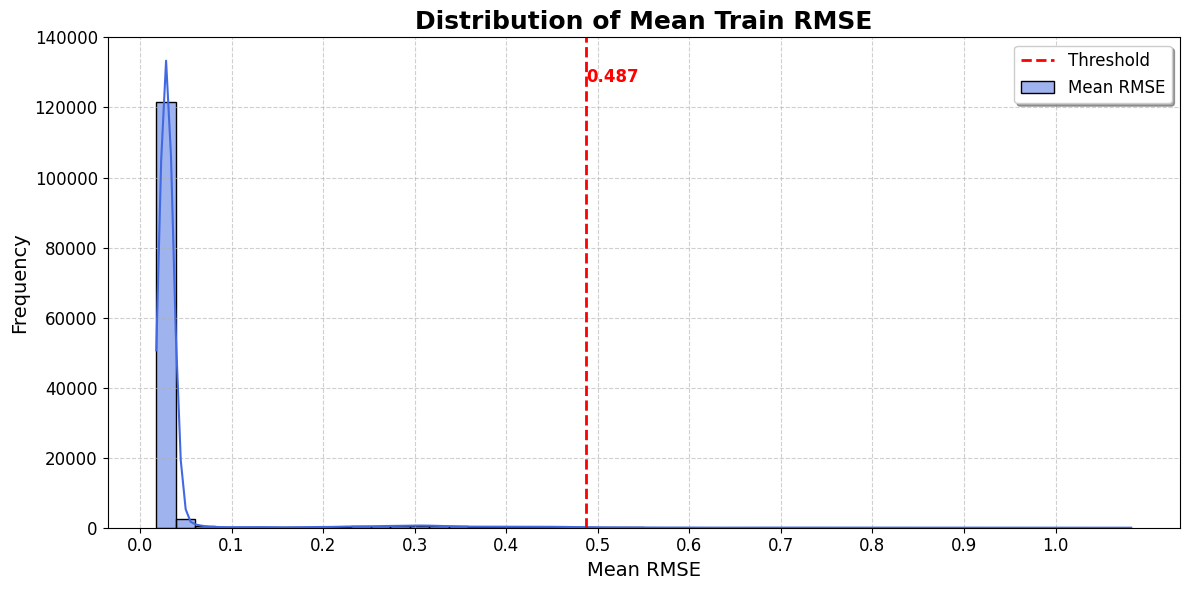

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

trainRMSE_mean = np.mean(trainRMSE, axis=1) 

# Print the shape and mean of trainRMSE_mean
print("Shape of trainRMSE_mean:", trainRMSE_mean.shape)
print("Mean of trainRMSE_mean:", np.mean(trainRMSE_mean))

# Compute the 95th and 99.5th percentiles
threshold_95 = np.percentile(trainRMSE_mean, 95)
threshold_99 = np.percentile(trainRMSE_mean, 99.5)
print("95th Percentile Threshold:", threshold_95)
print("99.5th Percentile Threshold:", threshold_99)

# Plot the distribution of the mean RMSE values
plt.figure(figsize=(12, 6))
sns.histplot(trainRMSE_mean, bins=50, color='royalblue', kde=True, label='Mean RMSE') 

# Highlight the threshold with a vertical line
plt.axvline(threshold_99, color='red', linestyle='--', linewidth=2, label='Threshold')

# Annotate the threshold value on the plot
plt.text(threshold_99, plt.gca().get_ylim()[1] * 0.9, f'{threshold_99:.3f}', 
         color='red', fontsize=12, fontweight='bold', ha='left', va='bottom')

# Customize x-axis ticks for better readability
x_ticks = np.arange(0, 1.1, 0.1)  # Set ticks every 0.1 instead of 0.05
plt.xticks(x_ticks, fontsize=12)
plt.yticks(fontsize=12)

# Add title and labels with improved fonts
plt.title('Distribution of Mean Train RMSE', fontsize=18, fontweight='bold')
plt.xlabel('Mean RMSE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend with improved styling
plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)

# Tight layout for a clean figure
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_545/79535465.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])
/tmp/ipykernel_545/79535465.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data[columns_to_replace] = combined_data[columns_to_replace].replace(0, 0.01)


            timestamp  jetson_gpu_usage_percent  jetson_cpu_usage_percent  \
0 2025-01-17 20:18:00                      0.01                  0.500000   
1 2025-01-17 20:18:01                      0.01                  0.833333   
2 2025-01-17 20:18:02                      0.01                  0.666667   
3 2025-01-17 20:18:03                      0.01                  0.833333   
4 2025-01-17 20:18:04                      0.01                  0.500000   

   jetson_board_temperature_celsius  jetson_ram_usage_mb  ground_truth  
0                         38.135167                 6231             0  
1                         38.077667                 6231             0  
2                         38.057000                 6231             0  
3                         38.150833                 6231             0  
4                         38.249500                 6231             0  
combined X shape (1481, 20, 4)
combined Y shape (1481, 4)
47/47 [==============================] - 

/tmp/ipykernel_545/79535465.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['anomaly'] = False


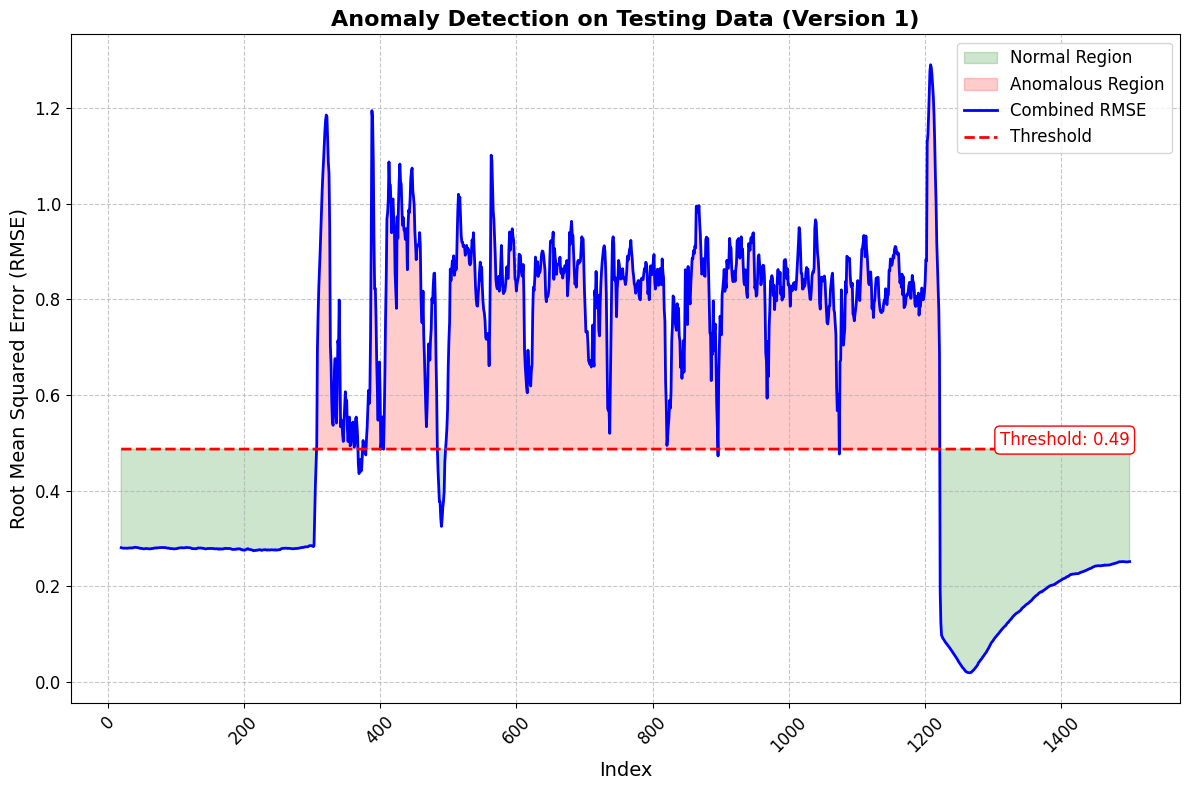

In [43]:
# Load the dataset
data1 = pd.read_csv('Nano08V1_gt.csv')  

# Select only the 'timestamp', 'jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', and 'ground_truth' columns
combined_data = data1[['timestamp', 'jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_ram_usage_mb', 'ground_truth']]

# Convert 'timestamp' to datetime format
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Replace zero values with a small value (0.01) for all columns except 'ground_truth'
columns_to_replace = combined_data.columns.difference(['ground_truth'])
combined_data[columns_to_replace] = combined_data[columns_to_replace].replace(0, 0.01)

# Verify the changes
print(combined_data.head())

# Filter rows where the timestamp's second is divisible by 5
# combined_data = combined_data[combined_data['timestamp'].dt.second % 5 == 0]

# Extract the columns to scale
df_to_scale = combined_data[['jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_ram_usage_mb']]

# Scale features individually
scaled_gpu = gpu_scaler.fit_transform(df_to_scale['jetson_gpu_usage_percent'].values.reshape(-1, 1))
scaled_temp = temp_scaler.fit_transform(df_to_scale['jetson_board_temperature_celsius'].values.reshape(-1, 1))
scaled_cpu = cpu_scaler.fit_transform(df_to_scale['jetson_cpu_usage_percent'].values.reshape(-1, 1))
scaled_ram = ram_scaler.fit_transform(df_to_scale['jetson_ram_usage_mb'].values.reshape(-1, 1))

# Create scaled DataFrame without specifying an index
df_standard_scaled_1 = pd.DataFrame({
    'jetson_gpu_usage_percent': scaled_gpu.flatten(),
    'jetson_board_temperature_celsius': scaled_temp.flatten(),
    'jetson_cpu_usage_percent': scaled_cpu.flatten(),
    'jetson_ram_usage_mb': scaled_ram.flatten()
})

# Add the timestamp column back
df_standard_scaled_1['timestamp'] = combined_data['timestamp'].reset_index(drop=True)

# Convert the combined dataset into sequences
combined_X, combined_Y = to_sequence(df_standard_scaled_1[['jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_ram_usage_mb']], df_standard_scaled_1[['jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_ram_usage_mb']], seq_size)

print("combined X shape", combined_X.shape)
print("combined Y shape", combined_Y.shape)


# Measure the time before starting the prediction
start_time = time.time()

# Use the trained model to predict the reconstruction errors (MAPE) on the combined dataset
combined_predict = model.predict(combined_X)

# Measure the time after prediction
end_time = time.time()

# Calculate total inference time
inference_time = end_time - start_time
print(f"Total inference time: {inference_time:.2f} seconds")

# Calculate combined MAPE
# combined_mape = np.mean(np.abs(combined_predict - combined_X) / combined_X, axis=1) * 100
combined_mae = np.mean(np.abs(combined_predict - combined_X), axis=1)
combined_mae_combined = np.mean(combined_mae, axis=1)

combined_mse = np.mean(np.square(combined_predict - combined_X), axis=1)
combined_mse_combined = np.mean(combined_mse, axis=1)

combined_rmse = np.sqrt(combined_mse)
combined_rmse_combined = np.mean(combined_rmse, axis=1)

# Thresholding using MAPE
max_trainRMSE = threshold_99
# max_trainRMSE = 0.69

# Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(df_standard_scaled_1[seq_size:])
anomaly_df['combinedRMSE'] = combined_rmse_combined
anomaly_df['max_trainRMSE'] = max_trainRMSE
anomaly_df['anomaly'] = anomaly_df['combinedRMSE'] > max_trainRMSE
anomaly_df[['jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_ram_usage_mb']] = df_standard_scaled_1[seq_size:][['jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_ram_usage_mb']]

# Add the anomaly flag to the original test dataset
combined_data['anomaly'] = False
combined_data.loc[anomaly_df.index, 'anomaly'] = anomaly_df['anomaly'].values

# Separate normal and anomalous data for plotting
normal_data = combined_data[~combined_data['anomaly']]
anomalous_data = combined_data[combined_data['anomaly']]

# Plot combined RMSE with adjusted highlighted regions
plt.figure(figsize=(12, 8))

# Highlight the area within the threshold in green
plt.fill_between(anomaly_df.index, anomaly_df['max_trainRMSE'], anomaly_df['combinedRMSE'], 
                 where=anomaly_df['combinedRMSE'] <= anomaly_df['max_trainRMSE'], 
                 color='green', alpha=0.2, label='Normal Region')

# Highlight the area above the threshold in red
plt.fill_between(anomaly_df.index, anomaly_df['max_trainRMSE'], anomaly_df['combinedRMSE'], 
                 where=anomaly_df['combinedRMSE'] > anomaly_df['max_trainRMSE'], 
                 color='red', alpha=0.2, label='Anomalous Region')

# Plot the RMSE values
sns.lineplot(x=anomaly_df.index, y=anomaly_df['combinedRMSE'], label='Combined RMSE', color='blue', linewidth=2)

# Plot the threshold line
sns.lineplot(x=anomaly_df.index, y=anomaly_df['max_trainRMSE'], label='Threshold', color='red', linestyle='--', linewidth=2)

# Annotate the threshold value
threshold_value = anomaly_df['max_trainRMSE'].iloc[0]  # Assuming the threshold is constant
plt.text(x=anomaly_df.index[-1], 
         y=threshold_value, 
         s=f'Threshold: {threshold_value:.2f}', 
         color='red', 
         fontsize=12, 
         verticalalignment='bottom', 
         horizontalalignment='right', 
         bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))

# Customize the plot
plt.title('Anomaly Detection on Testing Data (Version 1)', fontsize=16, fontweight='bold')
plt.xlabel('Index', fontsize=14)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add background color to make the plot more appealing
plt.gcf().set_facecolor('white')
plt.tight_layout()
plt.savefig('NFL_anomaly_detection_plot_BiLSTM_V1.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()




In [39]:
# # Load the dataset
# data1 = pd.read_csv('Nano08V1_gt.csv')  

# # Select only the 'timestamp', 'jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', and 'ground_truth' columns
# combined_data = data1[['timestamp', 'jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_ram_usage_mb', 'ground_truth']]

# # Convert 'timestamp' to datetime format
# combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# # Replace zero values with a small value (0.01) for all columns except 'ground_truth'
# columns_to_replace = combined_data.columns.difference(['ground_truth'])
# combined_data[columns_to_replace] = combined_data[columns_to_replace].replace(0, 0.01)

# # Verify the changes
# print(combined_data.head())

# # Filter rows where the timestamp's second is divisible by 5
# # combined_data = combined_data[combined_data['timestamp'].dt.second % 5 == 0]

# # Extract the columns to scale
# df_to_scale = combined_data[['jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_ram_usage_mb']]

# # Initialize the StandardScaler
# scaler_standard = StandardScaler()

# # Perform scaling
# df_standard_scaled_1 = pd.DataFrame(scaler_standard.fit_transform(df_to_scale), 
#                                   columns=df_to_scale.columns, 
#                                   index=combined_data.index)

# # Add the 'timestamp' column back to the scaled data
# df_standard_scaled_1['timestamp'] = combined_data['timestamp']

# # Plot the scaled data
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='timestamp', y='jetson_gpu_usage_percent', data=df_standard_scaled_1, label='GPU Usage (Standard)')
# sns.lineplot(x='timestamp', y='jetson_cpu_usage_percent', data=df_standard_scaled_1, label='CPU Usage (Standard)')
# sns.lineplot(x='timestamp', y='jetson_board_temperature_celsius', data=df_standard_scaled_1, label='Board Temperature (Standard)')
# sns.lineplot(x='timestamp', y='jetson_ram_usage_mb', data=df_standard_scaled_1, label='RAM Usage (Standard)')

# # Customize the plot
# plt.title('Scaled Jetson Device Metrics Over Time (Standard Scaler)')
# plt.ylabel('Standardized Values')
# plt.xlabel('Timestamp')
# plt.xticks(rotation=45)
# plt.gcf().set_facecolor('white')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Convert the combined dataset into sequences
# combined_X, combined_Y = to_sequence(df_standard_scaled_1[['jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_ram_usage_mb']], df_standard_scaled_1[['jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_ram_usage_mb']], seq_size)

# print("combined X shape", combined_X.shape)
# print("combined Y shape", combined_Y.shape)


# # Measure the time before starting the prediction
# start_time = time.time()

# # Use the trained model to predict the reconstruction errors (MAPE) on the combined dataset
# combined_predict = model.predict(combined_X)

# # Measure the time after prediction
# end_time = time.time()

# # Calculate total inference time
# inference_time = end_time - start_time
# print(f"Total inference time: {inference_time:.2f} seconds")

# # Calculate combined MAPE
# # combined_mape = np.mean(np.abs(combined_predict - combined_X) / combined_X, axis=1) * 100
# combined_mae = np.mean(np.abs(combined_predict - combined_X), axis=1)
# combined_mae_combined = np.mean(combined_mae, axis=1)

# combined_mse = np.mean(np.square(combined_predict - combined_X), axis=1)
# combined_mse_combined = np.mean(combined_mse, axis=1)

# combined_rmse = np.sqrt(combined_mse)
# combined_rmse_combined = np.mean(combined_rmse, axis=1)

# # Thresholding using MAPE
# # max_trainRMSE = threshold_99
# max_trainRMSE = 0.690

# # Capture all details in a DataFrame for easy plotting
# anomaly_df = pd.DataFrame(df_standard_scaled_1[seq_size:])
# anomaly_df['combinedRMSE'] = combined_rmse_combined
# anomaly_df['max_trainRMSE'] = max_trainRMSE
# anomaly_df['anomaly'] = anomaly_df['combinedRMSE'] < max_trainRMSE
# anomaly_df[['jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_ram_usage_mb']] = df_standard_scaled_1[seq_size:][['jetson_gpu_usage_percent', 'jetson_cpu_usage_percent', 'jetson_board_temperature_celsius', 'jetson_ram_usage_mb']]

# # Plot combined MAE vs max_trainMAE
# plt.figure(figsize=(10, 6))
# sns.lineplot(x=anomaly_df.index, y=anomaly_df['combinedRMSE'], label='RMSE')
# sns.lineplot(x=anomaly_df.index, y=anomaly_df['max_trainRMSE'], label='Threshold', linestyle='--', color='red')
# plt.xlabel('Date')
# plt.ylabel('Root Mean Sq Error (RMSE)')
# plt.title('Anomaly Detection on Testing Dataset')
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()

# # Add the anomaly flag to the original test dataset
# combined_data['anomaly'] = False
# combined_data.loc[anomaly_df.index, 'anomaly'] = anomaly_df['anomaly'].values

# # Separate normal and anomalous data for plotting
# normal_data = combined_data[~combined_data['anomaly']]
# anomalous_data = combined_data[combined_data['anomaly']]

# # # Plot the original metrics with anomalies highlighted
# # plt.figure(figsize=(14, 8))

# # # Plot normal data
# # sns.lineplot(x='timestamp', y='jetson_gpu_usage_percent', data=normal_data, label='GPU Usage (Normal)', color='blue')
# # sns.lineplot(x='timestamp', y='jetson_cpu_usage_percent', data=normal_data, label='CPU Usage (Normal)', color='green')
# # sns.lineplot(x='timestamp', y='jetson_board_temperature_celsius', data=normal_data, label='Board Temperature (Normal)', color='green')
# # sns.lineplot(x='timestamp', y='jetson_ram_usage_mb', data=normal_data, label='RAM Usage (Standard)')


# # # Overlay anomalous points
# # plt.scatter(anomalous_data['timestamp'], anomalous_data['jetson_gpu_usage_percent'], 
# #             color='red', label='GPU Usage (Anomalous)', s=40, zorder=3)
# # plt.scatter(anomalous_data['timestamp'], anomalous_data['jetson_cpu_usage_percent'], 
# #             color='orange', label='CPU Usage (Anomalous)', s=40, zorder=3)
# # plt.scatter(anomalous_data['timestamp'], anomalous_data['jetson_board_temperature_celsius'], 
# #             color='yellow', label='Board Temperature (Anomalous)', s=40, zorder=3)
# # plt.scatter(anomalous_data['timestamp'], anomalous_data['jetson_ram_usage_mb'], 
# #             color='yellow', label='RAM Usage (Anomalous)', s=40, zorder=3)

# # # Customize the plot
# # plt.title('Jetson Device Metrics with Anomalies Highlighted')
# # plt.xlabel('Timestamp')
# # plt.ylabel('Usage (%)')
# # plt.legend()
# # plt.xticks(rotation=45)
# # plt.gcf().set_facecolor('white')
# # plt.tight_layout()
# # plt.show()

# # Plot combined RMSE with adjusted highlighted regions
# plt.figure(figsize=(12, 8))

# # Highlight the area within the threshold in green
# plt.fill_between(anomaly_df.index, anomaly_df['max_trainRMSE'], anomaly_df['combinedRMSE'], 
#                  where=anomaly_df['combinedRMSE'] <= anomaly_df['max_trainRMSE'], 
#                  color='green', alpha=0.2, label='Normal Region')

# # Highlight the area above the threshold in red
# plt.fill_between(anomaly_df.index, anomaly_df['max_trainRMSE'], anomaly_df['combinedRMSE'], 
#                  where=anomaly_df['combinedRMSE'] > anomaly_df['max_trainRMSE'], 
#                  color='red', alpha=0.2, label='Anomalous Region')

# # Plot the RMSE values
# sns.lineplot(x=anomaly_df.index, y=anomaly_df['combinedRMSE'], label='Combined RMSE', color='blue', linewidth=2)

# # Plot the threshold line
# sns.lineplot(x=anomaly_df.index, y=anomaly_df['max_trainRMSE'], label='Threshold', color='red', linestyle='--', linewidth=2)

# # Customize the plot
# plt.title('Anomaly Detection on Jetson Device Metrics', fontsize=16, fontweight='bold')
# plt.xlabel('Index', fontsize=14)
# plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=14)
# plt.xticks(fontsize=12, rotation=45)
# plt.yticks(fontsize=12)
# plt.legend(fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.7)

# # Add background color to make the plot more appealing
# plt.gcf().set_facecolor('white')
# plt.tight_layout()

# # Show the plot
# plt.show()



Confusion Matrix:
[[579  21]
 [ 32 869]]
Precision: 0.98
Recall: 0.96
F1-Score: 0.97
Accuracy: 0.96


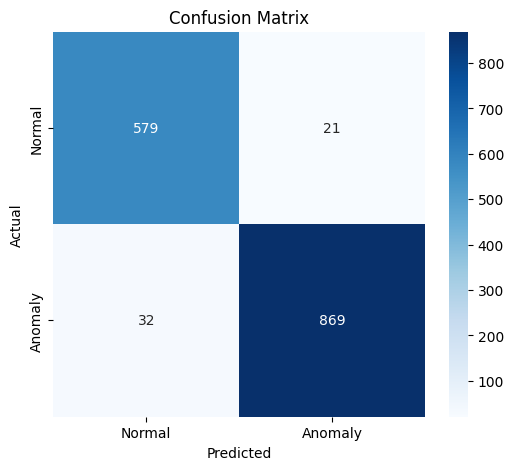

In [44]:
# Assuming 'anomaly' is the predicted anomalies (from your model)
# and 'ground_truth' is the true anomaly labels from the dataset.

# Compare ground truth with predicted anomalies (model's 'anomaly' column)
y_true = combined_data['ground_truth']  # Actual labels (0 or 1)
y_pred = combined_data['anomaly'].astype(int)  # Predicted anomalies (0 or 1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Precision, Recall, F1-Score, and Accuracy
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('NFL_CM_BiLSTM_V1.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
### Plot actual vs predicted values ###


def plot_predictions(data, predictions, columns, dataset_name, seq_size):
    """Plot actual vs predicted values"""
    fig, axes = plt.subplots(len(columns), 1, figsize=(15, 5*len(columns)))
    if len(columns) == 1:
        axes = [axes]
    
    for i, (ax, col) in enumerate(zip(axes, columns)):
        # Plot actual values
        ax.plot(data['datetimestamp'][seq_size:], data[col][seq_size:], 
                label='Actual', color='blue', alpha=0.6)
        
        # Plot predicted values
        ax.plot(data['datetimestamp'][seq_size:], predictions[:, i], 
                label='Predicted', color='green', alpha=0.6)
        
        ax.set_title(f'{dataset_name}: {col} - Actual vs Predicted')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    #plt.savefig(f'{dataset_name}_predictions.png')
    plt.show()
    plt.close()

def analyze_dataset(data_path: str, dataset_name: str, model):
    """Analyze dataset and generate predictions visualization"""
    # Load and preprocess data
    data = pd.read_csv(data_path)
    data['datetimestamp'] = pd.to_datetime(data['timestamp'])
    
    columns = [
        'jetson_gpu_usage_percent',
        'jetson_board_temperature_celsius',
        'jetson_cpu_usage_percent',
        'jetson_ram_usage_mb'
    ]
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[columns])
    scaled_df = pd.DataFrame(scaled_data, columns=columns)
    
    # Initialize variables
    seq_size = 20
    predictions = np.zeros((len(data) - seq_size, len(columns)))
    
    # Generate predictions using sliding window
    for i in range(len(data) - seq_size):
        sequence = scaled_df.iloc[i:i+seq_size].values.reshape(1, seq_size, len(columns))
        pred = model.predict(sequence, verbose=0)
        #predictions[i] = pred[0][10]  # Use the mid timestep prediction
        #predictions[i] = pred[0][-1]  # Use the last timestep prediction
        predictions[i] = pred[0][0]  # Use the first timestep prediction
    
    # Inverse transform predictions for plotting
    predictions = scaler.inverse_transform(predictions)
    
    # Generate visualization
    plot_predictions(data, predictions, columns, dataset_name, seq_size)
    
    # Analyze dataset
analyze_dataset('Nano07V1_gt.csv', 'V1_gt', model)
#analyze_dataset('Nano07V2_gt.csv', 'V2_gt', model)
analyze_dataset('Nano07V3_gt.csv', 'V3_gt', model)